The competition dataset is based on the [2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data) made available in Big Query on Google Cloud Platform. The data was originally published by the [NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

In [1]:
import warnings
import os
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

warnings.filterwarnings("ignore")

/home/bartosz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_path = os.path.join('Datasets', 'nyc_taxi', 'train.csv')
test_path = os.path.join('Datasets', 'nyc_taxi', 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

train_df = train_df.sample(frac=1)

In [3]:
print('Shape (train):', train_df.shape)
print('Shape (test):', test_df.shape)

train_df.head()

Shape (train): (1458644, 11)
Shape (test): (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1369225,id0274402,2,2016-01-01 12:17:41,2016-01-01 12:21:02,5,-73.974464,40.759205,-73.965576,40.771626,N,201
603550,id0334379,2,2016-05-26 14:24:05,2016-05-26 14:34:11,1,-73.987549,40.738411,-74.006729,40.740639,N,606
826250,id1143300,2,2016-03-13 01:50:09,2016-03-13 01:58:28,1,-73.987244,40.725208,-73.980690,40.742901,N,499
1206653,id2021117,2,2016-05-24 18:09:35,2016-05-24 18:38:04,6,-73.962181,40.779270,-73.982384,40.761688,N,1709
1401817,id2070335,2,2016-02-11 20:42:13,2016-02-11 20:50:18,2,-73.991531,40.726875,-73.985390,40.738071,N,485


There are 1 458 644 training rows and 625 134 testing rows. Data is relatively huge. There are 2 less columns in training data - trip duration (target) and dropoff datetime.

Data fields

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

In [4]:
print(train_df.isna().sum())
print(test_df.isna().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


There are no missing values. Let's see the distribution of labels.

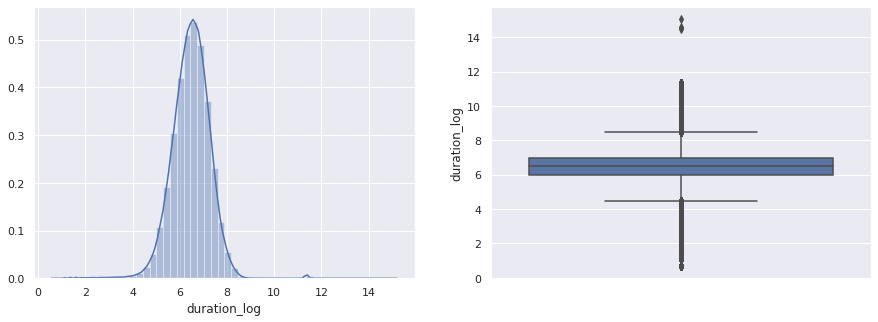

In [5]:
train_df['duration_log'] = np.log1p(train_df['trip_duration'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

### Removing outliers

In [6]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_b = q1 - 1.5 * iqr
    high_b = q3 + 1.5 * iqr
    mask = ((df[col] >= low_b)
            & (df[col] <= high_b))
    df = df.loc[mask]
    return df

In [7]:
train_df = remove_outliers(train_df, 'duration_log')

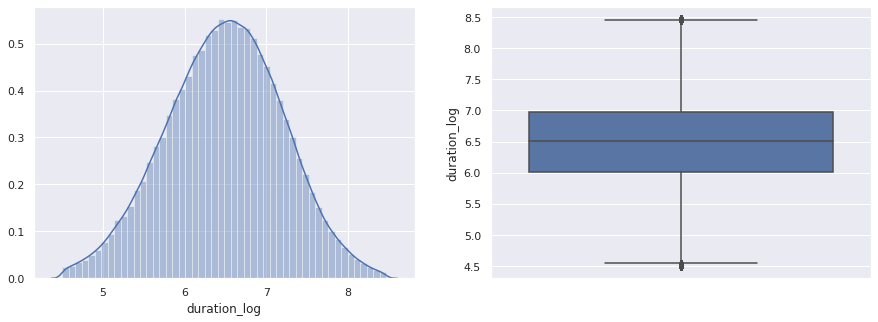

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

In [9]:
geo_cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']
for col in geo_cols:
    train_df = remove_outliers(train_df, col)

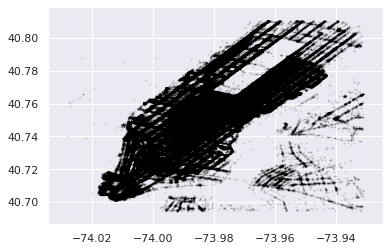

In [10]:
n = 100_000

plt.scatter(train_df.loc[:n, 'pickup_longitude'], train_df.loc[:n, 'pickup_latitude'],
            alpha=0.1, color='black', s=1)

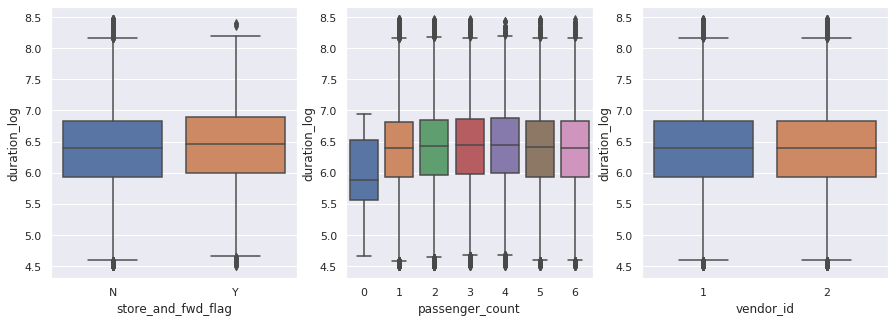

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols = ['store_and_fwd_flag', 'passenger_count', 'vendor_id']
for col, ax in zip(cols, axes):
    sns.boxplot(x=col, y='duration_log', data=train_df, ax=ax)

It is useful to calculate distances between pickup and dropoff points. There are a lot of different metrics. One of popular distances in geodesy are haversine distance and vincenty's distance. In that notebook I will not use them because I think they are especially useful for calculating huge distances and it is not a case for our dataset. That's why I believe euclidian distance will be enough. Additionally I will use manhattan distance.

In [12]:
def get_euclidian_dist(row):
    long_diff = row['dropoff_longitude'] - row['pickup_longitude']
    lati_diff = row['dropoff_latitude'] - row['pickup_latitude']
    dist = long_diff ** 2 + lati_diff ** 2
    return np.sqrt(dist)

def get_manhatan_dist(row):
    long_diff = row['dropoff_longitude'] - row['pickup_longitude']
    lati_diff = row['dropoff_latitude'] - row['pickup_latitude']
    dist = np.abs(long_diff) + np.abs(lati_diff)
    return dist

train_df['euc_dist'] = train_df.apply(get_euclidian_dist, axis=1)
train_df['man_dist'] = train_df.apply(get_manhatan_dist, axis=1)

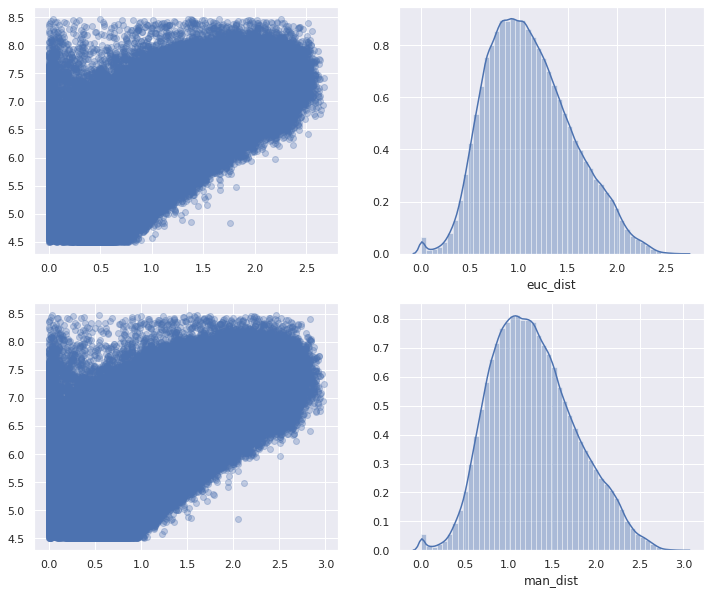

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flat
ax[0].scatter(np.log1p(train_df.loc[:n, 'euc_dist'] * 100), 
              train_df.loc[:n, 'duration_log'], alpha=0.3)
sns.distplot(np.log1p(train_df['euc_dist'] * 100), ax=ax[1])
ax[2].scatter(np.log1p(train_df.loc[:n, 'man_dist'] * 100), 
              train_df.loc[:n, 'duration_log'], alpha=0.3)
sns.distplot(np.log1p(train_df['man_dist'] * 100), ax=ax[3])

Well there is a correlation. Additionally it seems that both distances are very correlated and I should choose just one. I think manhattan distance is more reasonable.

### Dates and time

In [14]:
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['pickup_time'] = train_df['pickup_datetime'].dt.time

train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour

test_df['pickup_date'] = test_df['pickup_datetime'].dt.date
test_df['pickup_time'] = test_df['pickup_datetime'].dt.time

test_df['pickup_month'] = test_df['pickup_datetime'].dt.month
test_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour

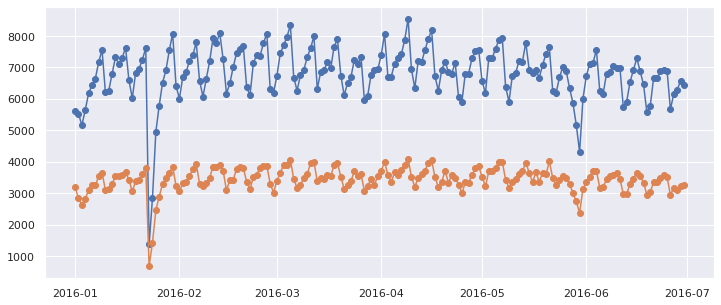

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(train_df.groupby('pickup_date')['id'].count(),
         '-o')
plt.plot(test_df.groupby('pickup_date')['id'].count(),
        '-o')

Train and test period overlaps.

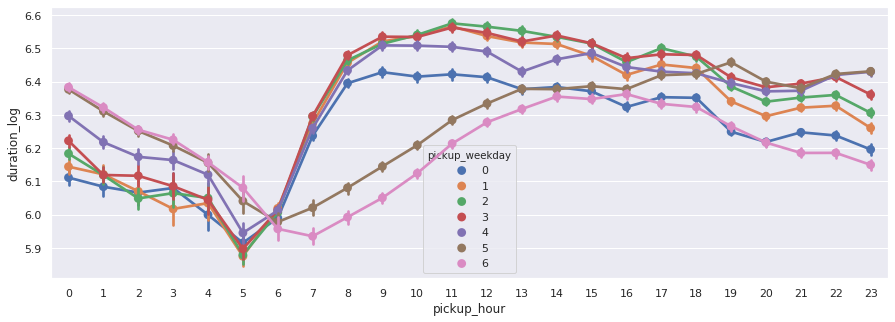

In [16]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='pickup_hour', y='duration_log', 
              hue='pickup_weekday', data=train_df)

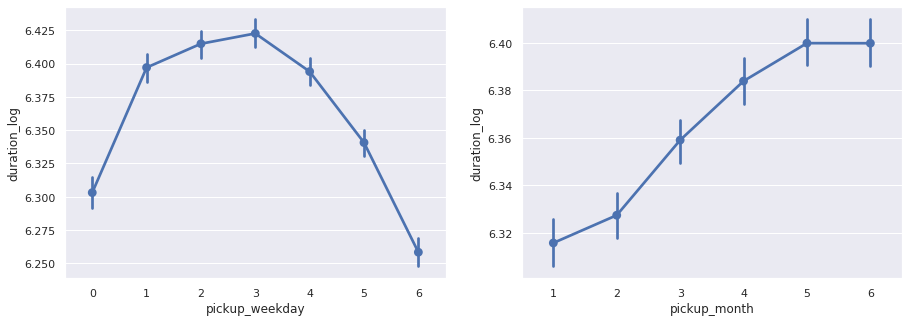

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.pointplot(x="pickup_weekday", y="duration_log", 
              data=train_df.iloc[:n], ax=axes[0])
sns.pointplot(x='pickup_month', y='duration_log',
              data=train_df.iloc[:n], ax=axes[1])

### Speed

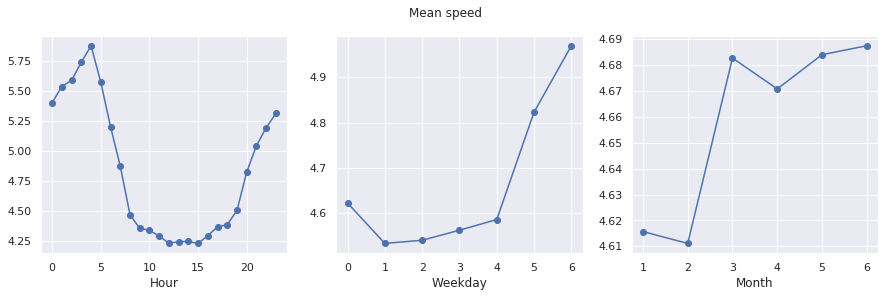

In [18]:
train_df['speed'] = (train_df['man_dist'] * 1000 / train_df['duration_log'])

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(train_df.groupby('pickup_hour')['speed'].mean(), '-o')
ax[0].set_xlabel('Hour')
ax[1].plot(train_df.groupby('pickup_weekday')['speed'].mean(), '-o')
ax[1].set_xlabel('Weekday')
ax[2].plot(train_df.groupby('pickup_month')['speed'].mean(), '-o')
ax[2].set_xlabel('Month')
fig.suptitle('Mean speed');

### New features

In [19]:
bin_cols = ['lat_bin', 'long_bin']
train_df[bin_cols] = np.round(train_df[['pickup_latitude', 'pickup_longitude']], 3)

In [20]:
speed_df = train_df.groupby(bin_cols)['speed'].mean()
speed_df = speed_df.reset_index()
speed_df.rename(columns={'speed': 'mean_speed'}, inplace=True)
count_df = train_df.groupby(bin_cols)['id'].count()
count_df = count_df.reset_index()
speed_df = pd.merge(speed_df, count_df, on=bin_cols)
speed_df = speed_df.loc[speed_df['id'] > 100]
speed_df.drop(columns='id', inplace=True)
speed_df.head()

,lat_bin,long_bin,mean_speed
208,40.701,-74.012,9.600728
234,40.702,-74.013,8.520833
235,40.702,-74.012,9.519039
236,40.702,-74.011,10.148956
266,40.703,-74.014,7.409790


In [21]:
temp = pd.merge(train_df, speed_df, how='left', on=bin_cols)
temp['mean_speed'].isna().sum() / temp['mean_speed'].shape[0]

0.050549528595017844

In [22]:
kmeans= MiniBatchKMeans(n_clusters=15, random_state=42, n_init=10)
districts = np.vstack((train_df[['pickup_longitude', 'pickup_latitude']],
                       train_df[['dropoff_longitude', 'dropoff_latitude']]))
kmeans.fit(districts)
for kind in ['pickup', 'dropoff']:
    cols = [f'{kind}_longitude', f'{kind}_latitude']
    train_df[f'{kind}_cluster'] = kmeans.predict(train_df[cols])

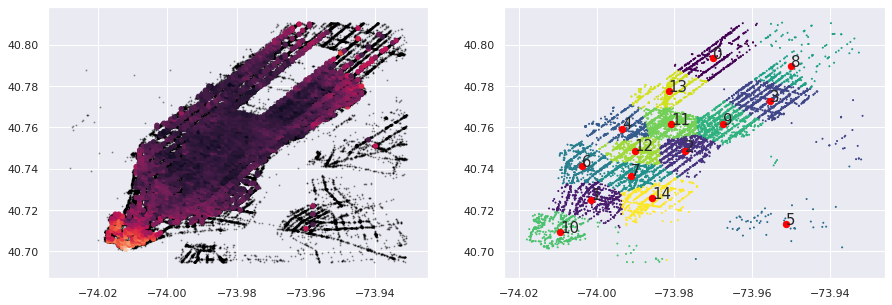

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(train_df.loc[:n, 'pickup_longitude'],
              train_df.loc[:n, 'pickup_latitude'],
              alpha=0.3, color='black', s=1)
ax[0].scatter(speed_df['long_bin'], speed_df['lat_bin'], 
              c=speed_df['mean_speed'], s=20)

x = train_df.iloc[:10_000]
ax[1].scatter(x['pickup_longitude'], x['pickup_latitude'], 
              c=x['pickup_cluster'], s=1, cmap='viridis')

centers = kmeans.cluster_centers_
lab_cent = zip(np.unique(kmeans.labels_) , centers)
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=40)
for label, center in lab_cent:
    ax[1].text(center[0], center[1], str(label), fontsize=15)

### Preprocessing

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [16]:
cols_to_drop = ['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration',
                'pickup_date', 'pickup_time']
train_df.drop(columns=cols_to_drop, inplace=True)
train_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,duration_log,distance,pickup_month,pickup_weekday,pickup_hour
50695,1,1,-73.978142,40.745560,-73.974297,40.755116,N,5.739793,0.010300,2,4,7
1113534,2,2,-73.986092,40.759022,-73.990181,40.734695,N,6.698268,0.024668,4,5,1
286502,2,2,-73.994766,40.750309,-73.979347,40.746120,N,6.538140,0.015978,6,6,12
161194,1,1,-73.998810,40.733212,-73.998367,40.724648,N,6.016157,0.008575,1,4,20
1323636,1,1,-74.002556,40.718826,-74.011536,40.707813,N,5.236442,0.014210,5,2,3


In [20]:
lb = LabelEncoder()
train_df['store_and_fwd_flag'] = lb.fit_transform(train_df['store_and_fwd_flag'])

In [23]:
X = train_df.drop(columns=['duration_log'])
Y = train_df['duration_log']

scaler = StandardScaler()
X = scaler.fit_transform(X)

### Machine Learning

In [34]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score

In [36]:
model = RidgeCV()
scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error')
np.sqrt(-np.mean(scores))

0.4693702321074115

In [35]:
model = LassoCV()
scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error')
np.sqrt(-np.mean(scores))

0.4693736880093177